## Paketlerin İçe Aktarılması

In [1]:
import os 
import matplotlib.pyplot as plt
import numpy as np
import glob
import shutil

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Dropout,Flatten,MaxPooling2D

## Verinin Yüklenmesi

In [2]:
_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

zip_file = tf.keras.utils.get_file(origin=_URL,
                                   fname="flower_photos.tgz",
                                   extract=True)

228827136/228813984 [==============================] - 2s 0us/step


In [3]:
#verinin ana dizini
base_dir = os.path.join(os.path.dirname(zip_file), 'flower_photos')

In [4]:
#dizindeki dosyalar
zip_dir_base = os.path.dirname(zip_file)
!find $zip_dir_base -type d -print

/root/.keras/datasets
/root/.keras/datasets/flower_photos
/root/.keras/datasets/flower_photos/tulips
/root/.keras/datasets/flower_photos/daisy
/root/.keras/datasets/flower_photos/roses
/root/.keras/datasets/flower_photos/dandelion
/root/.keras/datasets/flower_photos/sunflowers


In [5]:
#veri setindeki sınıflar
classes = ['tulips', 'daisy', 'roses', 'dandelion', 'sunflowers']

In [6]:
#train ve validation oluşturma
for cl in classes:
  img_path = os.path.join(base_dir, cl)
  images = glob.glob(img_path + '/*.jpg')
  print("{}: {} Images".format(cl, len(images)))
  train, val = images[:round(len(images)*0.8)], images[round(len(images)*0.8):]

  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
      os.makedirs(os.path.join(base_dir, 'train', cl))
    shutil.move(t, os.path.join(base_dir, 'train', cl))

  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
      os.makedirs(os.path.join(base_dir, 'val', cl))
    shutil.move(v, os.path.join(base_dir, 'val', cl))

tulips: 799 Images
daisy: 633 Images
roses: 641 Images
dandelion: 898 Images
sunflowers: 699 Images


In [7]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

## Veri Çoğaltma

In [8]:
batch_size = 100
IMG_SHAPE = 150 

#### Verileri Yatay Çevirme

In [9]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE,IMG_SHAPE)
                                                )

Found 2935 images belonging to 5 classes.


In [10]:
#resim göstermek için fonksiyon
def plotImages(images_arr):
  fig, axes = plt.subplots(1,5, figsize = (20,20)) #1e5'lik 20 20 büyüklüğünde pencere
  axes = axes.flatten() # axesi düzleştirme
  
  for image, ax in zip(images_arr, axes):
    ax.imshow(image) #resmi göster
  plt.tight_layout() #alt nokta parametreleri otomatik ayarlama(sığması için)
  plt.show() #pencereyi göster

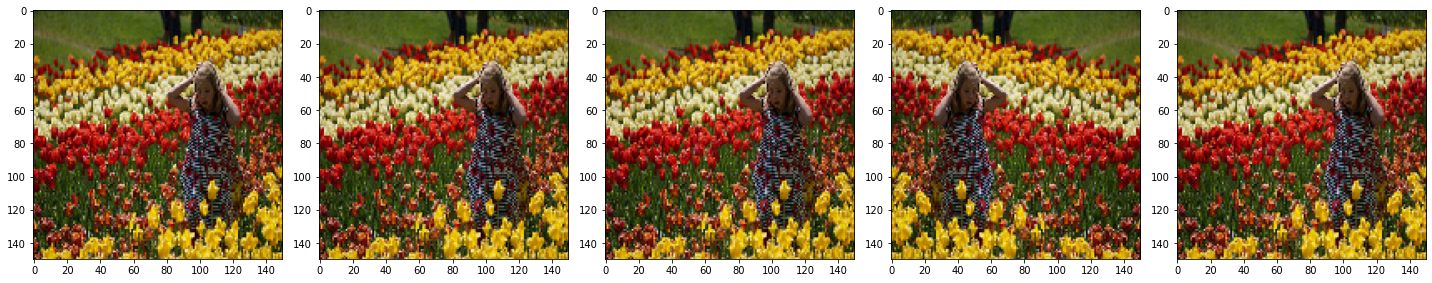

In [11]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

#### Resimleri Rastgele Döndürme

In [12]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))

Found 2935 images belonging to 5 classes.


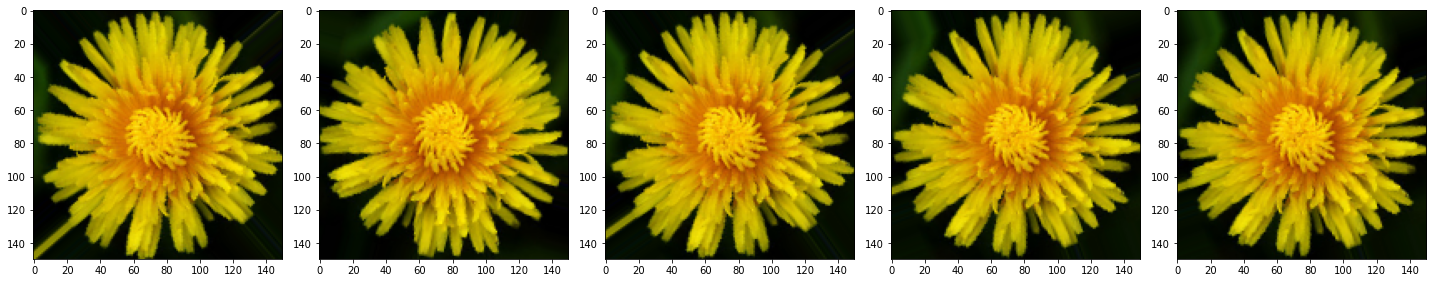

In [13]:
augmented_images = [train_data_gen[0][0][0] for i in range (5)]
plotImages(augmented_images)

#### Resimleri Rastgele Büyütme

In [14]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)

train_data_gen = image_gen.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE, IMG_SHAPE)
                                                )

Found 2935 images belonging to 5 classes.


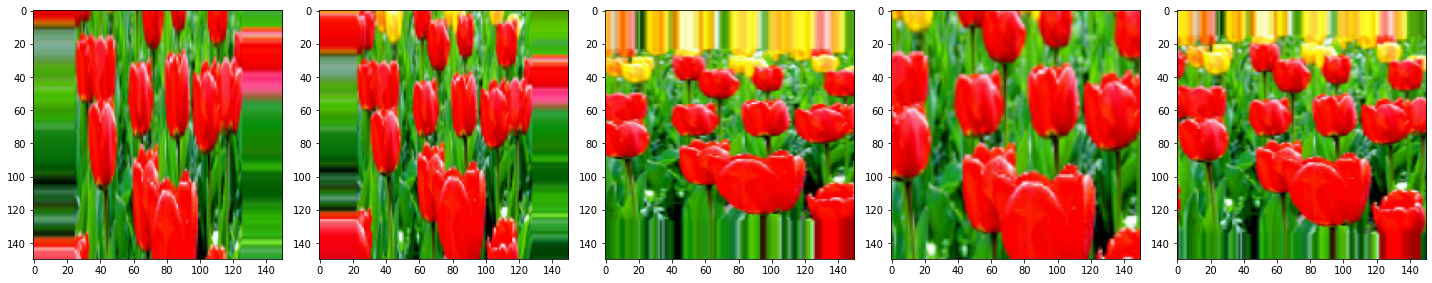

In [15]:
augmented_images = [train_data_gen[0][0][0] for i in range (5)]
plotImages(augmented_images)

#### Hepsini Uygulama

In [16]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )


train_data_gen = image_gen_train.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE,IMG_SHAPE),
                                                class_mode='sparse'
                                                )

Found 2935 images belonging to 5 classes.


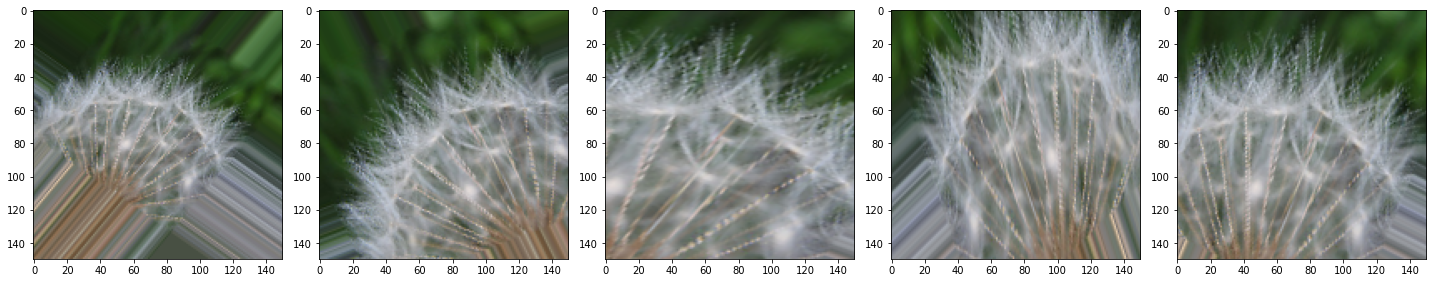

In [17]:
augmented_images = [train_data_gen[0][0][0] for i in range (5)]
plotImages(augmented_images)

#### Validation Seti Oluşturma

In [18]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=val_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='sparse')

Found 735 images belonging to 5 classes.


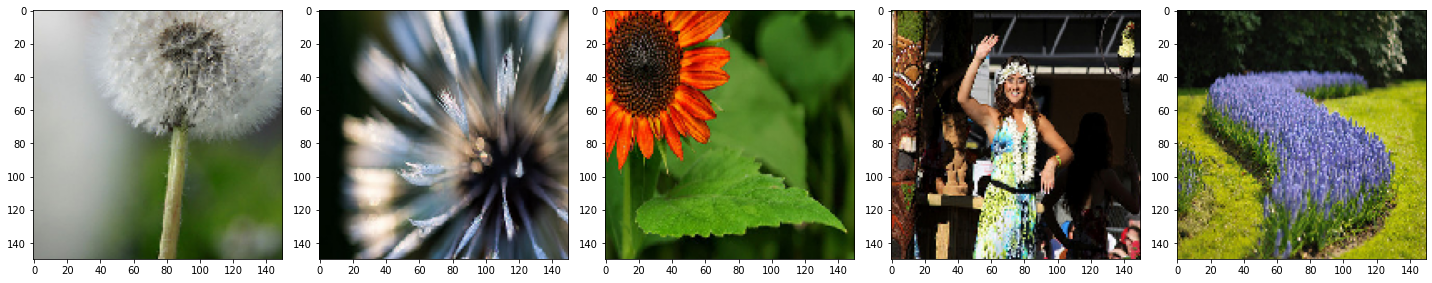

In [19]:
val_images,_ = next(val_data_gen)
plotImages(val_images[:5])

## Model Oluşturma

In [20]:
model = Sequential()

In [23]:
#katmanların eklenmesi
model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(5))

## Modelin Derlenmesi

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Modelin Eğitimi

In [25]:
epochs = 80

history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(batch_size))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(batch_size)))
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/80
30/30 [==============================] - 36s 868ms/step - loss: 1.6303 - accuracy: 0.3305 - val_loss: 1.3164 - val_accuracy: 0.4286
Epoch 2/80
30/30 [==============================] - 26s 877ms/step - loss: 1.2113 - accuracy: 0.4794 - val_loss: 1.2140 - val_accuracy: 0.4898
Epoch 3/80
30/30 [==============================] - 26s 872ms/step - loss: 1.0914 - accuracy: 0.5530 - val_loss: 1.1813 - val_accuracy: 0.5007
Epoch 4/80
30/30 [==============================] - 26s 896ms/step - loss: 1.0383 - accuracy: 0.5874 - val_loss: 1.0987 - val_accuracy: 0.5660
Epoch 5/80
30/30 [==============================] - 26s 882ms/step - loss: 0.9991 - accuracy: 0.5973 - val_loss: 1.0427 - val_accuracy: 0.5796
Epoch 6/80
30/30 [==============================] - 26s 880ms/step - loss: 0.9668 - accuracy: 0.6204 - val_loss: 0.9897 - val_accuracy: 0.6014
Epoch 7/80
30/30 [==============================] - 26s 874ms/step - loss: 0.9323 - accuracy: 0.6348 - val_loss: 0.9251 - val_accuracy: 0.6422

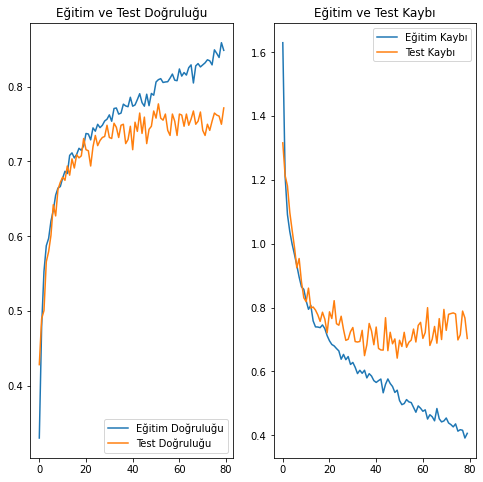

In [27]:
#eğitim ve testin kayıp ve doğruluklarının zaman içinde değişim grafiği
acc = history.history['accuracy'] #eğitim doğruluğu
val_acc = history.history['val_accuracy'] #test doğruluğu

loss = history.history['loss'] #eğitim kaybı
val_loss = history.history['val_loss'] #test kaybı

epochs_range = range(80) #epochs 100

plt.figure(figsize=(8, 8)) #8 8 büyüklüğünde pencere
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Eğitim Doğruluğu')
plt.plot(epochs_range, val_acc, label='Test Doğruluğu')
plt.legend(loc='lower right')
plt.title('Eğitim ve Test Doğruluğu')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Eğitim Kaybı')
plt.plot(epochs_range, val_loss, label='Test Kaybı')
plt.legend(loc='upper right')
plt.title('Eğitim ve Test Kaybı')
plt.show()